Importing Modules

In [3]:
import os
import numpy as np
import torch
from torchvision.models import efficientnet_b0, vit_b_16
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict

Preprocessing Dataset using Digital Image Processing

In [ ]:

# Define paths
data_dir = "dataset/"
processed_dir = "processed_dataset/"
os.makedirs(processed_dir, exist_ok=True)

# Define transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load and preprocess images
def preprocess_and_save(folder, save_folder):
    os.makedirs(save_folder, exist_ok=True)
    image_files = os.listdir(folder)
    for filename in tqdm(image_files, desc=f"Processing {folder}"):
        img_path = os.path.join(folder, filename)
        save_path = os.path.join(save_folder, filename)
        try:
            img = Image.open(img_path).convert("RGB")
            img = transform(img)
            torch.save(img, save_path.replace(".jpg", ".pt"))  # Save as tensor
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Process eczema, Acne and Rosacea Photos, and normal images
eczema_dir = os.path.join(data_dir, "eczema/")
Acne_Rosacea_dir = os.path.join(data_dir, "Acne and Rosacea Photos/")
normal_dir = os.path.join(data_dir, "normal/")

eczema_save_dir = os.path.join(processed_dir, "eczema/")
Acne_Rosacea_save_dir = os.path.join(processed_dir, "Acne and Rosacea Photos/")
normal_save_dir = os.path.join(processed_dir, "normal/")

preprocess_and_save(eczema_dir, eczema_save_dir)
preprocess_and_save(Acne_Rosacea_dir, Acne_Rosacea_save_dir)
preprocess_and_save(normal_dir, normal_save_dir)

print("✅ Preprocessing complete. Processed images saved.")


Processing dataset/Acne and Rosacea Photos/:   0%|          | 0/1544 [00:00<?, ?it/s]

Processing dataset/Acne and Rosacea Photos/: 100%|██████████| 1544/1544 [00:35<00:00, 43.59it/s]

✅ Preprocessing complete. Processed images saved.


Feature Extraction using EfficientNet and ViT (pre-trained models)

In [ ]:
# Define paths
data_dir = "processed_dataset/"
Acne_Rosacea_dir = os.path.join(data_dir, "Acne and Rosacea Photos/")
eczema_dir = os.path.join(data_dir, "eczema/")  # Added eczema folder
normal_dir = os.path.join(data_dir, "normal/")
feature_save_path = "extracted_features/"

# Create directory if not exists
os.makedirs(feature_save_path, exist_ok=True)

# Load Pretrained Models
efficientnet = efficientnet_b0(pretrained=True)
efficientnet.eval()

vit = vit_b_16(pretrained=True)
vit.eval()

# Feature Extraction Function
def extract_features(model, image):
    with torch.no_grad():
        features = model(image.unsqueeze(0))
    return features.squeeze().numpy()

# Process Images and Extract Features
def process_and_save_features(folder, save_filename):
    features_list = []
    image_files = os.listdir(folder)
    
    for filename in tqdm(image_files, desc=f"Processing {folder}"):
        img_path = os.path.join(folder, filename)
        try:
            image = torch.load(img_path)
            eff_features = extract_features(efficientnet, image)
            vit_features = extract_features(vit, image)
            combined_features = np.concatenate((eff_features, vit_features))
            features_list.append(combined_features)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    np.save(os.path.join(feature_save_path, save_filename), np.array(features_list))

# Extract features for all classes
process_and_save_features(Acne_Rosacea_dir, "Acne and Rosacea Photos.npy")
process_and_save_features(eczema_dir, "eczema_features.npy")  # Added eczema processing
process_and_save_features(normal_dir, "normal_features.npy")

print("✅ Feature extraction complete. Features saved for further use.")

c:\Users\ashub_bysvvo7\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ashub_bysvvo7\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ashub_bysvvo7\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent

✅ Feature extraction complete. Features saved for further use.


Feature Reduction(PCA) & Model training - XGBoost

🔄 Applying PCA for Feature Reduction...
✅ PCA Applied! New Shape: (4632, 2000)


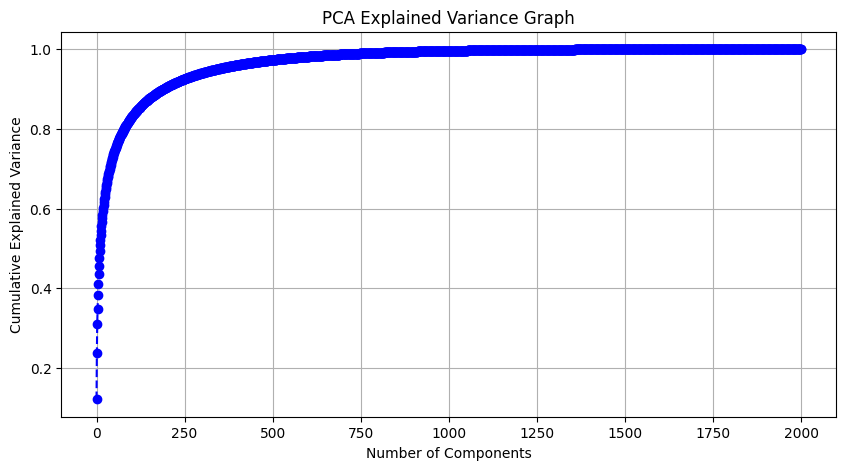

✅ PCA Model Saved as 'pca_model.pkl'
🚀 Training XGBoost Model...


c:\Users\ashub_bysvvo7\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:25:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model Saved as 'xgboost_skin_disease_model.pkl'
📊 Evaluating Model...
✅ Accuracy: 93.20%
🔍 Classification Report:
                precision    recall  f1-score   support

        Normal       0.96      0.97      0.96       309
Acne & Rosacea       0.92      0.93      0.92       309
        Eczema       0.92      0.89      0.91       309

      accuracy                           0.93       927
     macro avg       0.93      0.93      0.93       927
  weighted avg       0.93      0.93      0.93       927



In [7]:

# ✅ Load Feature Files (Ensure These Are Pre-Extracted)
normal_features = np.load("extracted_features/normal_features.npy")  # Shape: (num_samples, num_features)
disease1_features = np.load("extracted_features/Acne and Rosacea Photos.npy")
disease2_features = np.load("extracted_features/eczema_features.npy")

# ✅ Create Labels
normal_labels = np.zeros((normal_features.shape[0],))  # 0 for Normal
disease1_labels = np.ones((disease1_features.shape[0],))  # 1 for Disease 1
disease2_labels = np.full((disease2_features.shape[0],), 2)  # 2 for Disease 2

# ✅ Combine into a Single Dataset
X = np.vstack([normal_features, disease1_features, disease2_features])  # Features
y = np.hstack([normal_labels, disease1_labels, disease2_labels])  # Labels


print("🔄 Applying PCA for Feature Reduction...")
pca = PCA(n_components=min(2000, X.shape[1]))  # Ensure n_components is valid
X_pca = pca.fit_transform(X)  # ✅ Fit & Transform
print(f"✅ PCA Applied! New Shape: {X_pca.shape}")

# ✅ Plot PCA Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Graph")
plt.grid(True)
plt.show()

# ✅ Save PCA Model for Future Use
joblib.dump(pca, "pca_model.pkl")
print("✅ PCA Model Saved as 'pca_model.pkl'")

# ✅ Split into Train & Test Sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Train XGBoost Classifier
print("🚀 Training XGBoost Model...")
model = xgb.XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss", use_label_encoder=False)
model.fit(X_train, y_train)

# ✅ Save Trained XGBoost Model
model_filename = "xgboost_skin_disease_model.pkl"
joblib.dump(model, model_filename)
print(f"✅ Model Saved as '{model_filename}'")

# ✅ Evaluate the Model
print("📊 Evaluating Model...")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy * 100:.2f}%")

# ✅ Display Classification Report
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Acne & Rosacea", "Eczema"]))


Pre-processing & Feature Extraction of testing images

In [10]:


# ✅ Define Paths
image_folder = "new_images/"
feature_save_path = "new_images_features.npy"
image_names_path = "image_names.npy"

# ✅ Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ✅ Load Pretrained Models
efficient_net = efficientnet_b0(weights="IMAGENET1K_V1")
efficient_net.eval()

vit_model = vit_b_16(weights="IMAGENET1K_V1")
vit_model.eval()

# ✅ Feature Extraction Function
def extract_features(image_path):
    try:
        image = Image.open(image_path).convert("RGB")  # ✅ Corrected: Use PIL to load images
        image = transform(image)  # Apply transforms
        eff_features = efficient_net(image.unsqueeze(0)).detach().numpy().flatten()
        vit_features = vit_model(image.unsqueeze(0)).detach().numpy().flatten()
        return np.concatenate([eff_features, vit_features])
    except Exception as e:
        print(f"❌ Error processing {image_path}: {e}")
        return None

# ✅ Process Images & Extract Features
image_files = os.listdir(image_folder)
features_list = []
image_names = []

for filename in tqdm(image_files, desc="🔄 Extracting Features"):
    img_path = os.path.join(image_folder, filename)
    features = extract_features(img_path)
    if features is not None:
        features_list.append(features)
        image_names.append(filename)

# ✅ Save Extracted Features & Image Names
np.save(feature_save_path, np.array(features_list))
np.save(image_names_path, np.array(image_names))

print("✅ Feature Extraction Complete! Features saved.")


🔄 Extracting Features: 100%|██████████| 18/18 [00:12<00:00,  1.40it/s]

✅ Feature Extraction Complete! Features saved.


Classifying New images using trained model

In [11]:


# ✅ Load Trained XGBoost Model
xgb_model_path = "xgboost_skin_disease_model.pkl"
if not os.path.exists(xgb_model_path):
    raise FileNotFoundError("❌ Model file not found!")

model = joblib.load(xgb_model_path)

# ✅ Load Extracted Features & Image Names
feature_save_path = "new_images_features.npy"
image_names_path = "image_names.npy"

if not os.path.exists(feature_save_path) or not os.path.exists(image_names_path):
    raise FileNotFoundError("❌ Feature file or image names file not found!")

features = np.load(feature_save_path)  # ✅ Load Full Features (2560 dimensions)
image_names = np.load(image_names_path)

# ✅ Load PCA Model
pca_model_path = "pca_model.pkl"
if not os.path.exists(pca_model_path):
    raise FileNotFoundError("❌ PCA model file not found!")

pca = joblib.load(pca_model_path)

# ✅ Apply PCA for Feature Reduction
features = pca.transform(features)  # ✅ Transform only (DO NOT fit again)
print(f"🔹 Transformed Feature Shape (After PCA): {features.shape}")

# ✅ Predict Classes
predictions = model.predict(features)

# ✅ Class Labels (Modify According to Your Training Classes)
disease_classes = ["Normal", "Acne & Rosacea", "Eczema"]  # Modify if needed

# ✅ Categorize Results by Disease
categorized_results = defaultdict(list)
for i, image_name in enumerate(image_names):
    disease = disease_classes[int(predictions[i])]
    categorized_results[disease].append(image_name)

# ✅ Display Categorized Results
print("\n📌 **Classification Results (Categorized by Disease):**")
for disease, images in categorized_results.items():
    print(f"\n🔹 {disease} ({len(images)} images):")
    for img in images:
        print(f"   🖼️ {img}")


🔹 Transformed Feature Shape (After PCA): (18, 2000)

📌 **Classification Results (Categorized by Disease):**

🔹 Eczema (7 images):
   🖼️ 03DermatitisArm.jpg
   🖼️ acne-closed-comedo-8.jpg
   🖼️ Dyshidrosis-22.jpg
   🖼️ Dyshidrosis-23.jpg
   🖼️ eczema-areola-16.jpg
   🖼️ eczema-asteatotic-16.jpg
   🖼️ normal122.png

🔹 Acne & Rosacea (9 images):
   🖼️ 07AcnePittedScars1.jpg
   🖼️ 07rosaceaTreated091806OK.jpg
   🖼️ 07VascularFace0120.jpg
   🖼️ acne-closed-comedo-27.jpg
   🖼️ acne-open-comedo-4 - Copy.jpg
   🖼️ acne-pustular-9.jpg
   🖼️ dup_acne-cystic-18.jpg
   🖼️ dup_acne-excoriated-1 - Copy.jpg
   🖼️ dup_acne-open-comedo-64.jpg

🔹 Normal (2 images):
   🖼️ normal104.png
   🖼️ normal90.png


In [12]:
model.predict_proba(features)

array([[6.12509248e-05, 2.06336234e-04, 9.99732435e-01],
       [2.68241682e-04, 9.94010091e-01, 5.72168734e-03],
       [5.07565923e-02, 6.53397083e-01, 2.95846343e-01],
       [6.23467844e-04, 5.24548411e-01, 4.74828035e-01],
       [1.25897190e-04, 9.97790337e-01, 2.08385289e-03],
       [4.52002394e-04, 1.45147011e-01, 8.54400992e-01],
       [3.85878229e-05, 9.99401212e-01, 5.60155197e-04],
       [1.00058875e-04, 9.99854326e-01, 4.56109374e-05],
       [4.58583199e-05, 9.99139309e-01, 8.14824947e-04],
       [5.09535777e-04, 9.98728454e-01, 7.62026350e-04],
       [1.91793715e-05, 9.99917150e-01, 6.36716213e-05],
       [3.97426338e-05, 2.36635111e-04, 9.99723613e-01],
       [4.02679507e-05, 5.66559844e-04, 9.99393106e-01],
       [8.40906505e-05, 7.22729554e-03, 9.92688596e-01],
       [1.52451918e-04, 3.88510525e-04, 9.99459088e-01],
       [9.99814332e-01, 4.16652256e-05, 1.44022400e-04],
       [2.14524120e-01, 6.53035492e-02, 7.20172286e-01],
       [9.99769151e-01, 1.20855